In [105]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import Tensor
import torchvision

#### Setting device (checking if gpu is available for faster training)

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading the dataset and applying data augmentation

In [107]:
def load_cifar10(batch_size):
    # Transformations for the training data
    train_trans = transforms.Compose([
        transforms.RandomCrop(size=(32, 32), padding=4),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Transformations for the test data (minimal, without augmentation)
    test_trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Loading the datasets
    train = torchvision.datasets.CIFAR10(root="../data", train=True, transform=train_trans, download=True)
    test = torchvision.datasets.CIFAR10(root="../data", train=False, transform=test_trans, download=True)
    
    # Creating the DataLoaders
    train_loader = DataLoader(train, batch_size, shuffle=True, pin_memory=False)
    test_loader = DataLoader(test, batch_size, shuffle=False, pin_memory=False)
    
    return train_loader, test_loader


In [108]:
BATCH_SIZE = 64
train_iter, test_iter = load_cifar10(BATCH_SIZE)
for data in train_iter:
    print(data[0].size())
    print(data[1].size())
    break

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])
torch.Size([64])


### CIFAR-10 Dataset Analysis
Cifar-10 holds images if dimension 32x32
Cifar images also contain colour using the rgb format
Therefore each item in the dataset is of size 3x32x32


In [109]:
# hyper params



class Model(torch.nn.Module):
    
    """
    This class is the main model, it is made out of 7 Backbone blocks
    A backbone block is a class 'Block' defined below this one
    The model uses a MLP classifier made out of 3 linear layers
    All activation functions used are ReLU, and batch normalisation
    is used after every block (done within the block node itself)
    A block can also have a residual aspect to it, i.e O = f(x)+x,
    a feature taken from the resnet model from the lectures
    
    -----------------------------------------------------------------------
    
    We can view the architecture as 3 groups of blocks, each serpated
    by a pooling layer (either max or average) followed by a dropout operator
    
    The first group contains 2 blocks and an average pooling layer
    The second group contains 2 blocks and a max pooling layer
    The third group contains 3 blocks followed by a max pooling layer
    
    This then feeds into the spatial average pooling layer that passes
    its value into the 3 layer MLP classifier which outputs a vector of
    10 values
    
    """
    
    def __init__(self, in_channels, out_features):
        super(Model, self).__init__()
        
        # ==== hyper params ==== #
        # block group outputs
        B1_OUT = 32
        B2_OUT = 64
        B3_OUT = 128
        self.END_OUT = B3_OUT
        # mlp classifier layer outputs
        L1_OUT = 1024
        L2_OUT = 512
        # ====================== #
        
        # pooling layers
        self.maxpool = nn.MaxPool2d(2,2) 
        self.avgpool = nn.AvgPool2d(2,2) 
        
        # blocks
        self.block1 = Block(6,in_channels,B1_OUT, kernel_size=5, padding=2) 
        self.block2 = Block(6,B1_OUT,B1_OUT,kernel_size=5,padding=2)
        self.block3 = Block(6,B1_OUT,B2_OUT, kernel_size=3, padding=1)
        self.block4 = Block(6,B2_OUT,B2_OUT,kernel_size=3,padding=1,residual=True)
        self.block5 = Block(6,B2_OUT,B3_OUT,kernel_size=3, padding=1)
        self.block6 = Block(6,B3_OUT,B3_OUT,kernel_size=3,padding=1, residual=True)
        self.block7 = Block(6,B3_OUT,B3_OUT,kernel_size=3,padding=1, residual=True)


        # dropout layers
        self.d1 = nn.Dropout(0.1)        
        self.d2 = nn.Dropout(0.1)        
        self.d3 = nn.Dropout(0.15)        
        self.d4 = nn.Dropout(0.15)
        self.d5 = nn.Dropout(0.15)
        
        # Linear Layers + spatial pooling
        
        self.spatial_pool = nn.AdaptiveAvgPool2d(1)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(self.END_OUT,L1_OUT)
        self.linear2 = nn.Linear(L1_OUT,L2_OUT)
        self.linear3 = nn.Linear(L2_OUT, out_features)

    def forward(self, x):
        
        # block group 1
        out = self.activation(self.block1(x))
        out = self.activation(self.block2(out))
        out = self.avgpool(out) #16x16
        out = self.d1(out)
        
        # block group 2
        out = self.activation(self.block3(out))
        out = self.activation(self.block4(out))
        out = self.maxpool(out) # 8x8
        out = self.d2(out)

        # block group 3
        out = self.activation(self.block5(out))
        out = self.activation(self.block6(out))
        out = self.activation(self.block7(out))
        out = self.maxpool(out) # 4x4
        out = self.d3(out)

        # linear MLP layers and spatial pooling
        
        out = self.spatial_pool(out)
        out = out.reshape(-1 , self.END_OUT)

        out = self.linear1(out)
        out = self.activation(out)
        out = self.d4(out)

        out = self.linear2(out)
        out = self.activation(out)
        out = self.d5(out)

        out = self.linear3(out)
        return out


class Block(torch.nn.Module):
    def __init__(self, k, in_channels, out_channels, padding=2, kernel_size=5, stride=1,residual=False , batch_norm=True):
        """
        This class defines the block backbone mentioned on the coursework slides
        The adjustments ive made to the architecture is that the vector a is
        calculated from not only 1 linear layer of weights, but now a 3 layer MLP
        the output is still a vector of k weights.
        Another adjustment ive made is that after every block it applies batch normalisation
        to its output and returns it.
        
        The batch norm is calculated from the O value, not each individual (k) convolution
        
        """
        
        super(Block, self).__init__()
        self.batch_norm = batch_norm # if true will apply batch norm after this block
        self.residual = residual # if true will add the input to the output (residual connection)
        # === hyper params === #
        # output for mlp layer that calculates
        L1_OUT = 512
        L2_OUT = 512
        # ==================== #
        
        self.k = k
        self.out_channels = out_channels
        self.in_channels = in_channels
        # defining weight calculations (a)
        self.spatialAvgPool = nn.AdaptiveAvgPool2d(1)
        # flatten
        self.aLinear1 = nn.Linear(in_features=in_channels, out_features=L1_OUT)
        self.aLinear2 = nn.Linear(in_features=L1_OUT,out_features=L2_OUT)
        self.aLinear3 = nn.Linear(L2_OUT,k)
        self.activation = nn.ReLU()
        # defining the convolution section
        # creates k convolutions
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size ,padding=padding, stride=stride) for _ in range(k)])
        # self.batch_norms = nn.ModuleList([nn.BatchNorm2d(out_channels) for _ in range(k)])
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x: Tensor) -> Tensor:

        # apply spatial average pooling
        pooled: Tensor = self.spatialAvgPool(x)
        # flatten 
        pooled = pooled.view(pooled.size(0), -1) 
        # calculate a
        a: Tensor = self.activation(self.aLinear1(pooled))
        a = self.activation(self.aLinear2(a))
        a = self.aLinear3(a)

        O: Tensor = torch.zeros_like(self.convs[0](x))

        # Apply the convolutions and accumulate the weighted sum
        for i in range(self.k):
            conv = self.convs[i](x) # conv_i
            # the view is used to reshape the 1d tensor (a[:, i]) into a 4d tensor that is addition compatible with conv(x)
            O = O + a[:, i].view(-1, 1, 1, 1) * conv # this calculates a_1 conv_1 + ... + a_k conv_k, also applies activation function to it
        
        if self.batch_norm:
            O = self.batch_norm(O)
        
        if self.residual:
            O= O + x
        
        return O # returns [batchsize, c, h, w]


### Training The Model

In [110]:
# accumulator class from the utils file, used to calculate metrics

class Accumulator:
    
    def __init__(self, n) -> None:
        self.data = [0.0] * n
    
    # deletes all data and information stored
    def reset(self) -> None:
        self.data = [0.0] * len(self.data)
    
    # takes in n inputs, for each arg it adds it to its corresponding index in data
    def add(self, *args) -> None:
        self.data = [a + float(b) for a,b in zip(self.data, args)]
    
    # allows the indexing operator to be used
    def __getitem__(self, idx) -> any:
        return self.data[idx]
    
    def toList(self) -> list:
        return self.data
    
    def percentage(self, index, total):
        return 100 * self[index] / total if total > 0 else 0

In [111]:
import matplotlib.pyplot as plt

"""
Training loop for my model.
It trains over all the items in the trainset
For each iteration it calculates the loss and uses that to calculate
the gradient of the loss wrt the weight and takes a step in that direction to
minimise the loss (which then maximises accuracy). Once it iterates through
all the values, it then stores the average loss and training accuracy for
graph plotting

The testing stage is done right after training and the model is explicitly 
set to evaluation mode so it doesnt learn from the test set.
It then uses the test set to calculate the respective test accuracy for this epoch

"""

def trainingLoop(num_epoch, train_iter, test_iter, net, loss_function, optimizer) -> tuple[int, list[float], list[float], list[float]]:
    loss_values = [] 
    training_accuracy_values = []  
    testing_accuracy_values = []

    for epoch in range(num_epoch):
        # train on trianing set to obtain updated weights
        train_metrics = train(train_iter, net, loss_function, optimizer) # tuple (loss , accuracy)
        # testing new weights on unseen data
        test_accuracy = test(test_iter, net)
        # data for plotting
        loss_values.append(train_metrics[0])
        training_accuracy_values.append(train_metrics[1]) 
        testing_accuracy_values.append(test_accuracy)

        print(f'Epoch {epoch+1}, Average Loss: {loss_values[-1]}, Training Accuracy: {training_accuracy_values[-1]}, Testing Accuracy {testing_accuracy_values[-1]}')
        
    return(num_epoch, loss_values, training_accuracy_values, testing_accuracy_values)


def test(data_iter, net) -> float:
    net.eval() # set to testing mode
    
    metrics = Accumulator(2) # [correct, total]
    
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            # Get model predictions
            y_hat = net(X)
            # Convert probabilities to predicted class labels
            _, predicted_labels = torch.max(y_hat, 1)
            # Accumulate the number of correct predictions and the total to metrics
            metrics.add((predicted_labels == y).sum().item(), y.size(0))
    
    # Calculate accuracy
    accuracy = metrics[0] / metrics[1]
    
    # Set the network back to training mode
    net.train()
    
    return accuracy

def train(data_iter, net, loss_function, optimizer) -> tuple[float , float]:
    net.train()
    
    metrics = Accumulator(3)  # [sum of losses, correct predictions, total predictions]
    for X, Y in data_iter:  # get x and corresponding y value
        X, Y = X.to(device), Y.to(device)
        
        y_hat = net(X)  # get prediction
        loss = loss_function(y_hat, Y)  # loss of this specific value
        optimizer.zero_grad()  # clear gradient
        loss.backward()  # calculate derivative of loss w.r.t the weight
        optimizer.step()  # change weight values accordingly
        # add the sum of all equivilant, total is size of Y 
        metrics.add(loss.item(), (torch.max(y_hat, 1)[1] == Y).float().sum().item(), Y.size(0))
    # Calculate average loss and accuracy from the accumulated values
    avg_loss = metrics[0] / metrics[2]
    accuracy = metrics[1] / metrics[2]
    
    return (avg_loss, accuracy)


In [112]:
"""
Function to plot test and training accuracy aswell as training loss
"""
def plotTraining(num_epoch, loss_values, train_accuracy_values, test_accuracy_values):
    fig, ax1 = plt.subplots()

    # Training Loss
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(range(1, num_epoch+1), loss_values, '-o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis to share the same x-axis
    ax2 = ax1.twinx()  

    # Training Accuracy and Testing Accuracy
    color_train = 'tab:blue'
    color_test = 'tab:orange'
    ax2.set_ylabel('Accuracy', color=color_train)  # We already handled the x-label with ax1
    # Plot training accuracy on ax2
    ax2.plot(range(1, num_epoch+1), train_accuracy_values, '-s', color=color_train, label='Train Accuracy')
    # Plot testing accuracy on ax2 as well
    ax2.plot(range(1, num_epoch+1), test_accuracy_values, '-^', color=color_test, label='Test Accuracy')
    ax2.tick_params(axis='y', labelcolor=color_train)
    ax2.legend(loc='upper left')

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title('Training Loss and Accuracy')
    plt.show()


In [113]:
"""
Simple inistialsation of weights using xavier normal or linear
and convolutional layers
"""

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_normal_(m.weight)
        # torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')


In [114]:
model = Model(3, 10).to(device)
# model = Model(3, 10)
model.apply(init_weights)

loss = nn.CrossEntropyLoss()
lr = 0.002
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5) 

Epoch 1, Average Loss: 0.030700880861282347, Training Accuracy: 0.24652, Testing Accuracy 0.3161
Epoch 2, Average Loss: 0.026120075430870054, Training Accuracy: 0.35732, Testing Accuracy 0.422
Epoch 3, Average Loss: 0.023002301712036134, Training Accuracy: 0.45316, Testing Accuracy 0.4966
Epoch 4, Average Loss: 0.02047726799607277, Training Accuracy: 0.52686, Testing Accuracy 0.5448
Epoch 5, Average Loss: 0.01878171049118042, Training Accuracy: 0.56968, Testing Accuracy 0.6008
Epoch 6, Average Loss: 0.017334357171058655, Training Accuracy: 0.6085, Testing Accuracy 0.6368
Epoch 7, Average Loss: 0.016287829840183256, Training Accuracy: 0.63242, Testing Accuracy 0.667
Epoch 8, Average Loss: 0.015540613657236099, Training Accuracy: 0.65214, Testing Accuracy 0.6723
Epoch 9, Average Loss: 0.014765454753637313, Training Accuracy: 0.67028, Testing Accuracy 0.7026
Epoch 10, Average Loss: 0.014266061156392097, Training Accuracy: 0.68338, Testing Accuracy 0.683
Epoch 11, Average Loss: 0.013563726

ValueError: 'tab:black' is not a valid value for color

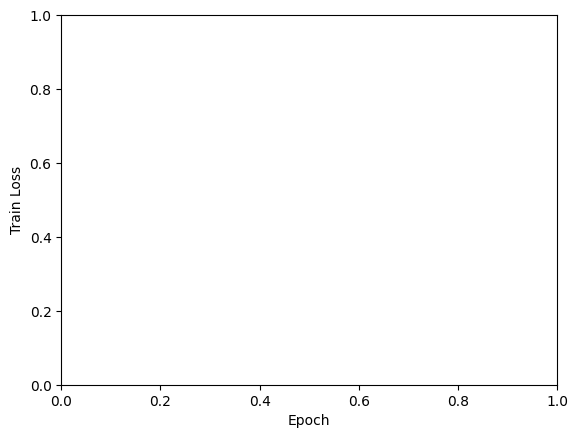

In [115]:
num_epochs = 100
params = trainingLoop(num_epochs,train_iter,test_iter ,model, loss, optimizer)
plotTraining(*params) # displays graph